In [1]:
# Basics
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import time
from datetime import datetime
import json
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.backend import clear_session
import matplotlib.pyplot as plt 

# Custom
import sys
sys.path.insert(0, '../../src/utils')
from data_loader import DataLoader
import constants
sys.path.insert(0, '../../src/modeling')
from network import Network
import evaluation as ev

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [10]:
hp = {
    'hidden_layers':      5,
    'hidden_neurons':     200,
    # 'dropout_rate':       0.5,
    'optimizer':          'adam',
    'learning_rate':      1e-4,
    'batch_size':         128
}

In [11]:
callbacks = []

callbacks.append(EarlyStopping(
    monitor='val_loss', 
    patience=35))

callbacks.append(ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-8))

In [12]:
# PLOT_HISTORY FUNCTION
def plot_history(history, i):
    f, ax = plt.subplots(2, 1, figsize=(10,12))
    
    ax[0].plot(history['loss'], label='train_loss')
    ax[0].plot(history['val_loss'], label='val_loss')
    ax[0].axhline(y=history['loss'][-1], ls='--', linewidth=0.5)
    ax[0].axhline(y=history['val_loss'][-1], ls='--', linewidth=0.5)
    ax[0].set_title('Train-Loss vs Val-Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    
    ax[1].plot(history['accuracy'], label='train_acc')
    ax[1].plot(history['val_accuracy'], label='val_acc')
    ax[1].axhline(y=history['accuracy'][-1], ls='--', linewidth=0.5)
    ax[1].axhline(y=history['val_accuracy'][-1], ls='--', linewidth=0.5)
    ax[1].set_title('Train-Acc vs Val-Acc')
    ax[1].set_ylabel('Acc')
    ax[1].set_xlabel('Epochs')
      
    plt.show()
    # f.savefig(
    #     f'./train_history_{i}keys.png', 
    #     bbox_inches='tight', 
    #     dpi=100
    # )

In [13]:
def save_results(ge, test_config, score, i):

    ge_dict = {f'{j+1}traces': el for j, el in enumerate(ge)}
    ge_dict['test_config'] = test_config
    ge_dict['score'] = score
    ge_df = pd.DataFrame(ge_dict, index=[0])
        
    if f'res_{i}keys.csv' not in os.listdir('./'):
        ge_df.to_csv(f'./res_{i}keys.csv', index=False)
    else:
        df = pd.read_csv(f'./res_{i}keys.csv')
        df = pd.concat([df, ge_df]).reset_index(drop=True)
        df.to_csv(f'./res_{i}keys.csv', index=False)
        

        
# originally in visual.py
def plot_ge_per_trainConfig(ges, scores, test_configs, n, i):
        
    # Get the colorset
    cmap = plt.cm.jet # Google Turbo
    colors = cmap(range(0, cmap.N, int(cmap.N/len(ges))))
    
    # Plot
    f, ax = plt.subplots(figsize=(10,5))
    ax.plot(np.zeros(n), color='r', ls='--', linewidth=0.5)

    for i, ge in enumerate(ges):
        if n <= 100:
            ax.plot(ge[:n], label=f'vs{test_configs[i]}', color=colors[i], marker='o')
            ax.set_xticks(range(n), labels=range(1, n+1))
            ax.grid()
        else:
            ax.plot(ge[:n], label=test_configs[i], color=colors[i])
        ax.legend()
        ax.set_title(f'Train config: #dev={len(train_devs)}, #keys={i}')
        ax.set_xlabel('Number of traces')
        ax.set_ylabel('GE')

    plt.show()
#     f.savefig(
#         f'./GE_{n}_{i}keys.png', 
#         bbox_inches='tight', 
#         dpi=100)
    
        
        
def plot_results(ge_test_traces, i):

    df = pd.read_csv(f'./res_{i}keys.csv')
    ges = df.loc[:, :f'{ge_test_traces}traces'].values
    test_configs = list(df['test_config'])
    scores = list(df['score'])

    # plot_ge_per_trainConfig(ges, scores, test_configs, int(ge_test_traces/2), i)
    plot_ge_per_trainConfig(ges, scores, test_configs, ge_test_traces, i)

::::::::::  Number of keys: 9  ::::::::::
Epoch 1/100
313/313 [==============================] - 1s 3ms/step - loss: 5.5429 - accuracy: 0.0052 - val_loss: 5.5321 - val_accuracy: 0.0064 - lr: 1.0000e-04
Epoch 2/100
313/313 [==============================] - 1s 2ms/step - loss: 5.1249 - accuracy: 0.0181 - val_loss: 5.2596 - val_accuracy: 0.0171 - lr: 1.0000e-04
Epoch 3/100
313/313 [==============================] - 1s 2ms/step - loss: 4.1161 - accuracy: 0.0618 - val_loss: 4.7995 - val_accuracy: 0.0311 - lr: 1.0000e-04
Epoch 4/100
313/313 [==============================] - 1s 2ms/step - loss: 3.7653 - accuracy: 0.0845 - val_loss: 4.1296 - val_accuracy: 0.0526 - lr: 1.0000e-04
Epoch 5/100
313/313 [==============================] - 1s 2ms/step - loss: 3.6250 - accuracy: 0.1013 - val_loss: 4.3863 - val_accuracy: 0.0480 - lr: 1.0000e-04
Epoch 6/100
313/313 [==============================] - 1s 2ms/step - loss: 3.5418 - accuracy: 0.1111 - val_loss: 4.1528 - val_accuracy: 0.0589 - lr: 1.0000e-0

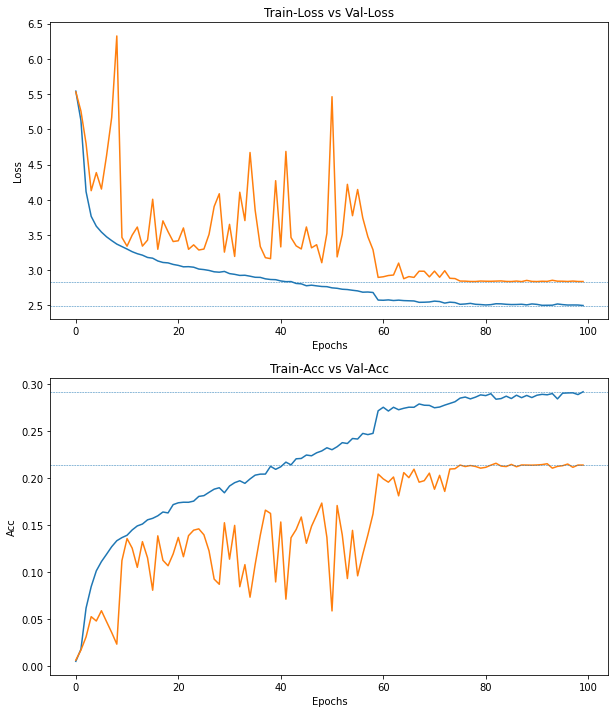

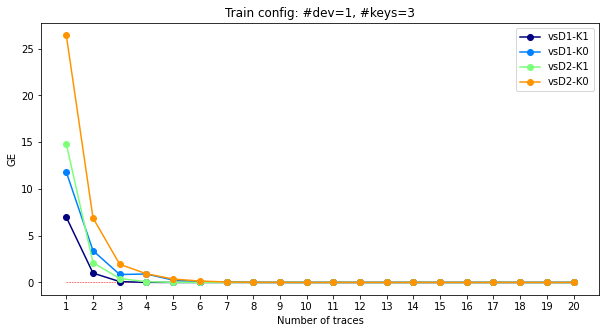


::::::::::  Number of keys: 10  ::::::::::
Epoch 1/100
313/313 [==============================] - 1s 3ms/step - loss: 5.5400 - accuracy: 0.0054 - val_loss: 5.5008 - val_accuracy: 0.0114 - lr: 1.0000e-04
Epoch 2/100
313/313 [==============================] - 1s 2ms/step - loss: 5.0259 - accuracy: 0.0198 - val_loss: 4.6877 - val_accuracy: 0.0319 - lr: 1.0000e-04
Epoch 3/100
313/313 [==============================] - 1s 2ms/step - loss: 4.0513 - accuracy: 0.0641 - val_loss: 5.7518 - val_accuracy: 0.0197 - lr: 1.0000e-04
Epoch 4/100
313/313 [==============================] - 1s 2ms/step - loss: 3.7470 - accuracy: 0.0887 - val_loss: 4.0156 - val_accuracy: 0.0642 - lr: 1.0000e-04
Epoch 5/100
313/313 [==============================] - 1s 2ms/step - loss: 3.6054 - accuracy: 0.1059 - val_loss: 3.6361 - val_accuracy: 0.1036 - lr: 1.0000e-04
Epoch 6/100
313/313 [==============================] - 1s 2ms/step - loss: 3.5175 - accuracy: 0.1151 - val_loss: 3.7353 - val_accuracy: 0.0970 - lr: 1.0000e

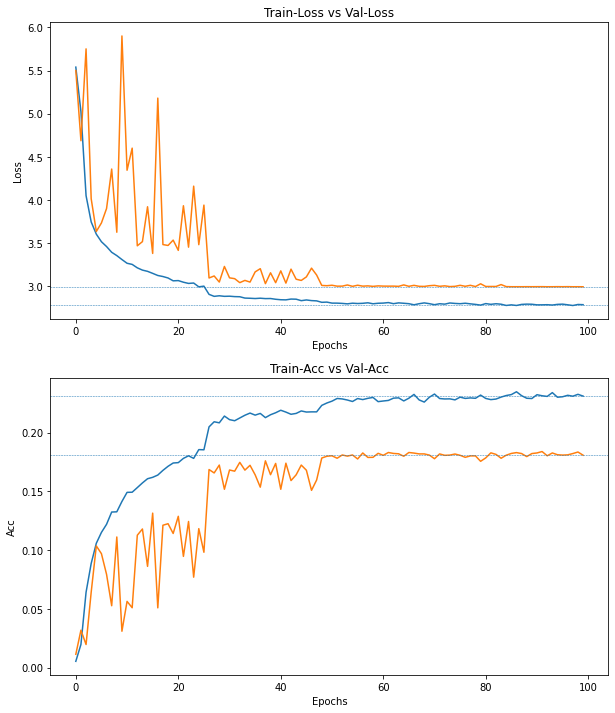

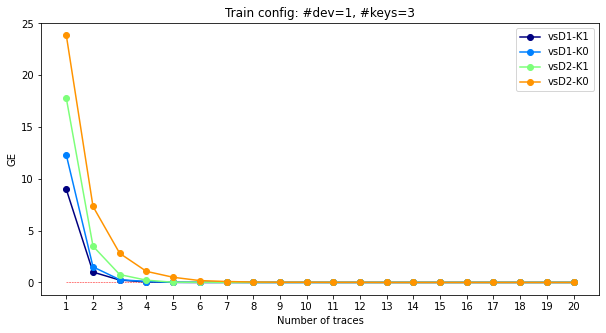

In [14]:
# Global variables (constants)
BYTE_IDX = 0
GE_TEST_TRACES = 20

# TRAIN_CONFIGS = ['D1-K1', 'D1-K2']
TEST_CONFIGS = ['D1-K1', # Same Device, Same Key
                'D1-K0', # Same Device, Different Key
                'D2-K1', # Different Device, Same Key
                'D2-K0'] # Different Device, Different Key]

train_devs = ['D1']
for i in range(9, len(constants.KEYS)): 
    
    print(f'::::::::::  Number of keys: {i}  ::::::::::')
    
    train_configs = [f'{dev}-{k}' for k in list(constants.KEYS)[1:i+1]
                     for dev in train_devs]

    train_paths = [constants.CURR_DATASETS_PATH + f'/SBOX_OUT/{c}_train.json' for c in train_configs]
    val_paths = [constants.CURR_DATASETS_PATH + f'/SBOX_OUT/{c}_test.json' for c in train_configs]

    train_dl = DataLoader(train_paths, BYTE_IDX)
    x_train, y_train, _, _ = train_dl.load_data()

    val_dl = DataLoader(val_paths, BYTE_IDX)
    x_val, y_val, _, _ = val_dl.load_data()
    
    model = create_model(hp)
    history = model.fit(
        x_train, 
        y_train, 
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=hp['batch_size'],
        callbacks=callbacks,
        verbose=1).history
    
    plot_history(history, i)
    
    
    for test_config in TEST_CONFIGS:
    
        test_path = constants.CURR_DATASETS_PATH + f'/SBOX_OUT/{test_config}_test.json'
        test_dl = DataLoader([test_path], BYTE_IDX)

        ge = ev.guessing_entropy(
            model,
            test_dl=test_dl,
            n_exp=100,
            n_traces=GE_TEST_TRACES)

        score = ev.ge_score(ge, 5)
        # print(f'Attack Score vs {test_config}: {score}')

        save_results(ge, test_config, score, i)
    
    plot_results(GE_TEST_TRACES, i)
    
    clear_session()
    print()

In [ ]:
# all_configs = [f'{TRAIN_CONFIG[:2]}-{k}' for k in constants.KEYS]
# all_configs.append('D3-K0')

# for test_config in all_configs:
    
#     test_path = constants.CURR_DATASETS_PATH + f'/SBOX_OUT/{test_config}_test.json'
#     test_dl = DataLoader([test_path], BYTE_IDX)
    
#     ge = ev.guessing_entropy(
#     model,
#     test_dl=test_dl,
#     n_exp=10,
#     n_traces=GE_TEST_TRACES)

#     score = ev.ge_score(ge, 10)
#     print(f'Attack Score vs {test_config}: {score}')
    
#     save_results(ge, test_config, score)

In [ ]:
# plot_results(GE_TEST_TRACES)